## Library

In [1]:
import sys
import os
import glob

sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp_rnn.ckpt"

# Remove saved checkpoints
files = glob.glob('../storage/demo/*')
for f in files:
    os.remove(f)

In [3]:
import numpy as np               
import pandas as pd
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.15.0'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

from neuralprocesses.np.cnp import ConditionalNeuralProcess

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

## Data

In [6]:
data = pd.read_csv('daily-min-temperatures.csv', sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(['Date'])
data['X'] = np.arange(len(data))
data

,Temp,X
Date,,
1981-01-01,20.7,0
1981-01-02,17.9,1
1981-01-03,18.8,2
1981-01-04,14.6,3
1981-01-05,15.8,4
...,...,...
1990-12-27,14.0,3645
1990-12-28,13.6,3646
1990-12-29,13.5,3647


## Data Preprocessing

In [7]:
data_train = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[:365*4]
data_test_1 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*4:365*8]

mean_value = data_train['T'].mean()
data_train['T'] = (data_train['T'] - mean_value)/mean_value
data_test_1['T'] = (data_test_1['T'] - mean_value)/mean_value

for s in range(1,2):
    data_train['Y'.format(s)] = data_train['T'].shift(s)
    data_test_1['Y'.format(s)] = data_test_1['T'].shift(s)

data_train = data_train.dropna()
data_test_1 = data_test_1.dropna()
X_train = data_train.drop(['X','T'], axis=1)
y_train = data_train.drop(['X','Y'], axis=1)
X_test_1 = data_test_1.drop(['X','T'], axis=1)
y_test_1 = data_test_1.drop(['X','Y'], axis=1)

print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test 1 size: (%d x %d)'%(y_test_1.shape[0], y_test_1.shape[1]))

Train size: (1460 x 1)
Test 1 size: (1460 x 1)


### LSTM Dataset

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return pd.DataFrame(np.array(dataX)), pd.DataFrame(np.array(dataY))

In [9]:
dataX, dataY = create_dataset(data['Temp'],3)
X_train_lstm = dataX[:363+365*3]
y_train_lstm = dataY[:363+365*3]
X_test_1_lstm = dataX[363+365*3:363+365*7]
y_test_1_lstm = dataY[363+365*3:363+365*7]

mean_X_train_lstm = X_train_lstm.mean()
mean_y_train_lstm = y_train_lstm.mean()
X_train_lstm = (X_train_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_train_lstm = (y_train_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_1_lstm = (X_test_1_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_1_lstm = (y_test_1_lstm - mean_y_train_lstm)/mean_y_train_lstm

# reshape input to be [samples, time steps, features]
X_train_lstm = np.reshape(X_train_lstm.values, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_1_lstm = np.reshape(X_test_1_lstm.values, (X_test_1_lstm.shape[0], X_test_1_lstm.shape[1], 1))

## RNN Model

In [10]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

nn = Sequential()
nn.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
nn.add(Dense(1))

adam = Adam(lr=0.1, beta_1=0.92, beta_2=0.999, decay=0.0, amsgrad=False)
nn.compile(optimizer=adam, loss='mean_absolute_error')
nn.summary()
history_nn = nn.fit(x=X_train, y=y_train, batch_size=1, epochs=17, verbose=1, callbacks=None)
y_pred_nn_1 = nn.predict(X_test_1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Train on 1460 samples
Epoch 1/17
1460/1460 [==============================] - 1s 685us/sample - loss: 0.2605
Epoch 2/17
1460/1460 [==============================] - 1s 612us/sample - loss: 0.2690
Epoch 3/17
1460/1460 [==============================] - 1s 605us/sample - loss: 0.2667
Epoch 4/17
1460/1460 [==============================] - 1s 604us/sample - loss: 0.2749
Epoch 5/17
1460/1460 [==============================] - 1s 614us/sample - loss: 0.2714
Epoch 6/17
1460/1460 [==============================] - 1s 628us/

## LSTM Model

In [11]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

model = Sequential()
model.add(LSTM(15, input_shape=(3, 1), recurrent_activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()
model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=5, verbose=1)
y_pred_lstm_1 = model.predict(X_test_1_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Train on 1458 samples
Epoch 1/15
1458/1458 [==============================] - 1s 715us/sample - loss: 0.2604
Epoch 2/15
1458/1458 [==============================] - 1s 454us/sample - loss: 0.1947
Epoch 3/15
1458/1458 [==============================] - 1s 439us/sample - loss: 0.1908
Epoch 4/15
1458/1458 [==============================] - 1s 452us/sample - loss: 0.1893
Epoch 5/15
1458/1458 [==============================] - 1s 456us/sample - loss: 0.1878
Epoch 6/15
1458/1458 [==============================] - 1s 

## CNP Data

In [12]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

In [13]:
def target_split(data, interval):
    target_index_list = list([True if (i+1)%interval==0 else False for i in list(np.arange(0, data.shape[0], 1))])
    context_index_list = list([False if (i+1)%interval==0 else True for i in list(np.arange(0, data.shape[0], 1))])
    target = data.loc[target_index_list]
    context = data.loc[context_index_list]
    return context, target

In [14]:
BATCH_SIZE = 1
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
interval_num = 3
context_cnp, target_cnp = target_split(data_train,interval_num)
context_test_1, target_test_1 = target_split(data_test_1,interval_num)

# Choose the number of context points
num_context_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

# Choose the number of target points
num_target_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

In [15]:
# Train
x_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 1
x_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

In [16]:
import collections
RegressionInput = collections.namedtuple(
    "RegressionInput",
    ("queries", "targets", "num_context", "num_target"))
data = RegressionInput(queries=((x_context, y_context), x_target), targets=y_target, num_context=num_context_points, num_target=num_target_points)

## GP Model

In [17]:
#kernel = lambda x: squared_exponential_kernel(x, 2.0)
gp_model = GaussianProcess(squared_exponential_kernel, name="gp-model")

In [18]:
_, gp_mean, gp_variance, _ = gp_model(((x_context, y_context), x_target))

In [19]:
with tf.variable_scope("gp_plot"):
    gp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    gp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0]], axis=1), 0)
    gp_plot_max = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] + tf.sqrt(gp_variance[0])], axis=1), 0)
    gp_plot_min = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] - tf.sqrt(gp_variance[0])], axis=1), 0)

## CNP Model

In [20]:
cnp = ConditionalNeuralProcess(name="cnp-model", aggregator="Mean")

In [21]:
cnp_mean, cnp_variance, cnp_loss = cnp(data)

In [22]:
with tf.variable_scope("cnp_trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(cnp_loss)

In [23]:
with tf.variable_scope("cnp_plot"):
    cnp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    cnp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0]], axis=1), 0)
    cnp_plot_max = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] + tf.sqrt(cnp_variance[0])], axis=1), 0)
    cnp_plot_min = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] - tf.sqrt(cnp_variance[0])], axis=1), 0)

### Training

In [24]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
NUM_EPISODES = 1500
SAVE_STEP = 100

with tf.Session() as session:
    
    # Initialize variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver( 
        max_to_keep=4, 
        keep_checkpoint_every_n_hours=1
    )
    session.run(init)

    # Do training
    for episode in tqdm(range(NUM_EPISODES)):
        session.run(training_step, feed_dict={plotting_mode: False})

        if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
            saver.save(session, SAVE_PATH, global_step=episode)

    # Save resulting graph
    print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

100%|██████████| 1500/1500 [00:03<00:00, 399.75it/s]


Model saved in: ../storage/demo/cnp_rnn.ckpt


## Prediction

In [26]:
def gp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [gp_plot_context, gp_plot_mean, gp_plot_max, gp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy

In [27]:
def cnp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [cnp_plot_context, cnp_plot_mean, cnp_plot_max, cnp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy, xymax, xymin

In [28]:
with tf.Session() as session:
    xc_train, yc_train, xt_train, yt_train = session.run([
        x_context[0], y_context[0], x_target[0], y_target[0]], feed_dict={plotting_mode: True})
    xc, yc, xt, yt = session.run([
        x_context_test[0], y_context_test[0], x_target_test[0], y_target_test[0]], feed_dict={plotting_mode: True})

# Result

### - RNN

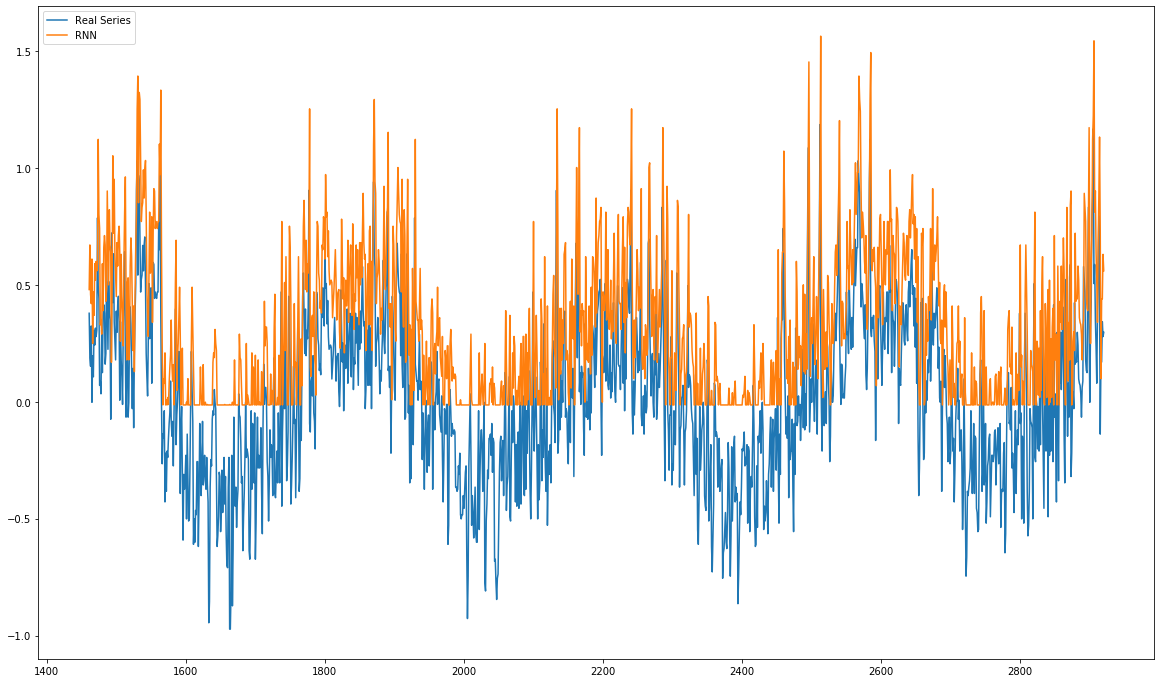

MSE RNN P1:    0.15


In [29]:
y_pred_nn_1=pd.DataFrame(y_pred_nn_1, index=y_test_1.index)
plt.figure(figsize=(20,12))
plt.plot(y_test_1, label='Real Series')
plt.plot(y_pred_nn_1, label='RNN')
plt.legend()
plt.show()
print("MSE RNN P1: {0:7.2f}".format((np.square(y_test_1 - y_pred_nn_1.values)).values.mean()))

### - LSTM

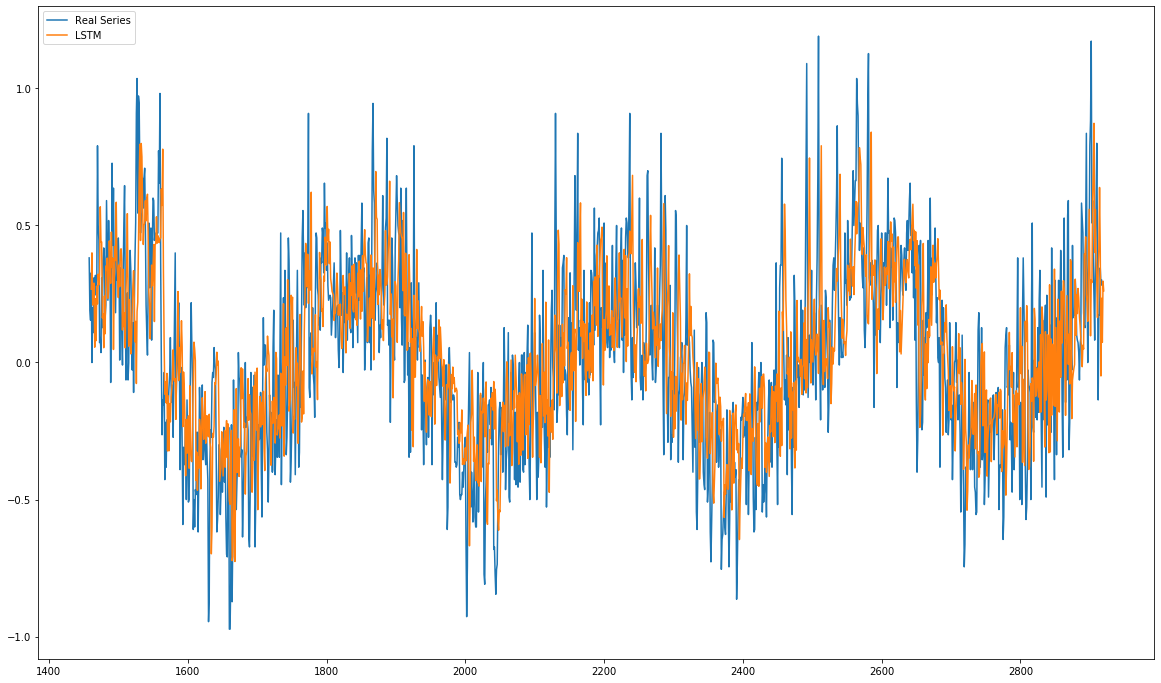

MSE LSTM P1:    0.05


In [30]:
y_pred_lstm_1=pd.DataFrame(y_pred_lstm_1, index=y_test_1.index)
plt.figure(figsize=(20,12))
plt.plot(y_test_1_lstm, label='Real Series')
plt.plot(y_pred_lstm_1, label='LSTM')
plt.legend()
plt.show()
print("MSE LSTM P1: {0:7.2f}".format((np.square(y_test_1_lstm - y_pred_lstm_1.values)).values.mean()))

### - GP
#### Part 1

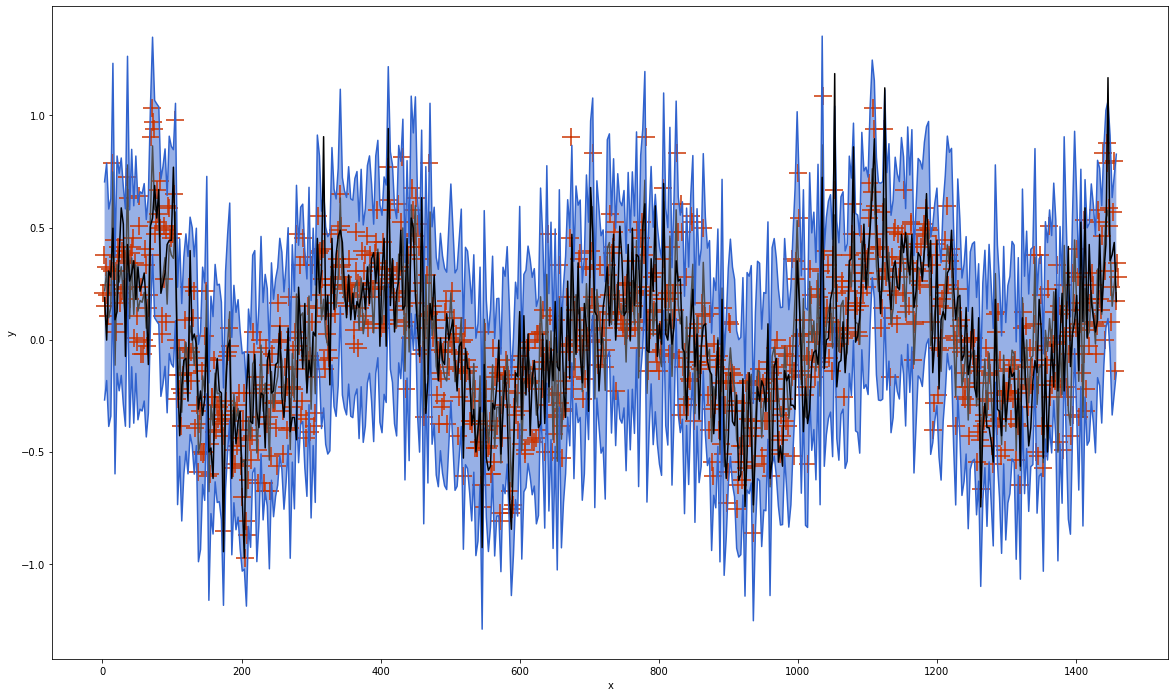

MSE GP:    0.04


In [31]:
plt.figure(figsize=(20,12))
pred_gp = gp_predict(xc_train, yc, xt_train, np.transpose([xt_train, yt]))
print("MSE GP: {0:7.2f}".format((np.square(yt - pred_gp[:,1])).mean()))

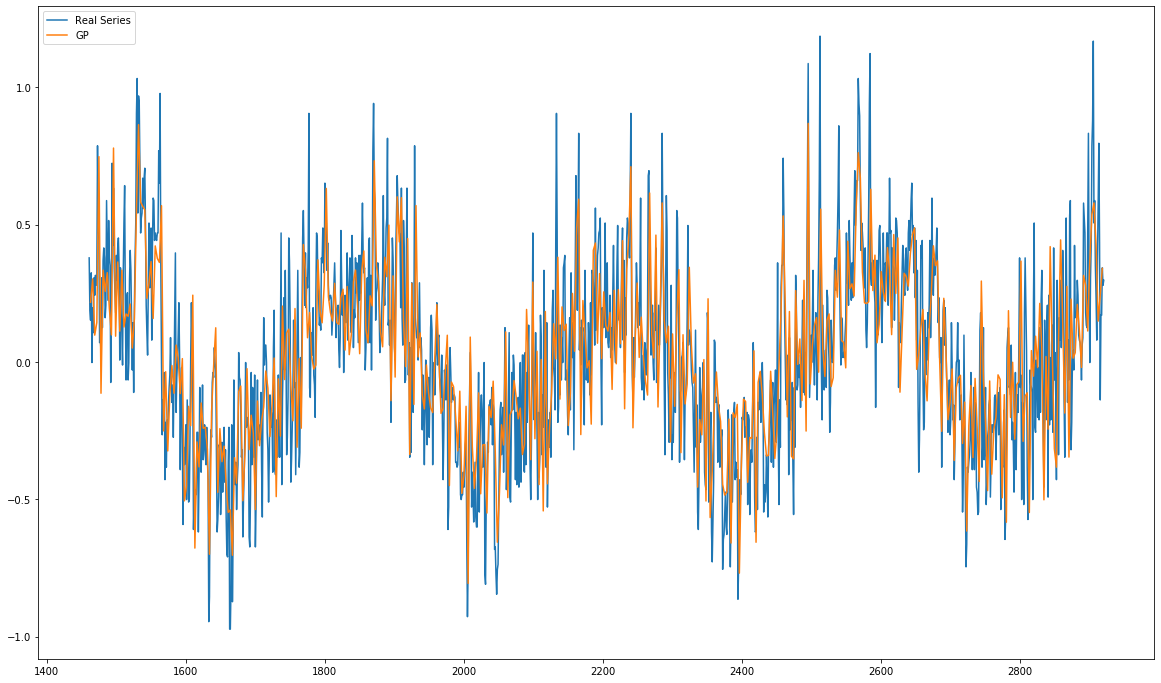

In [32]:
y_pred_gp_1=pd.DataFrame(pred_gp, index=xt.astype(int))[1]

plt.figure(figsize=(20,12))
plt.plot(y_test_1, label='Real Series')
plt.plot(y_pred_gp_1, label='GP')
plt.legend()
plt.show()

### - CNP
#### Part 1

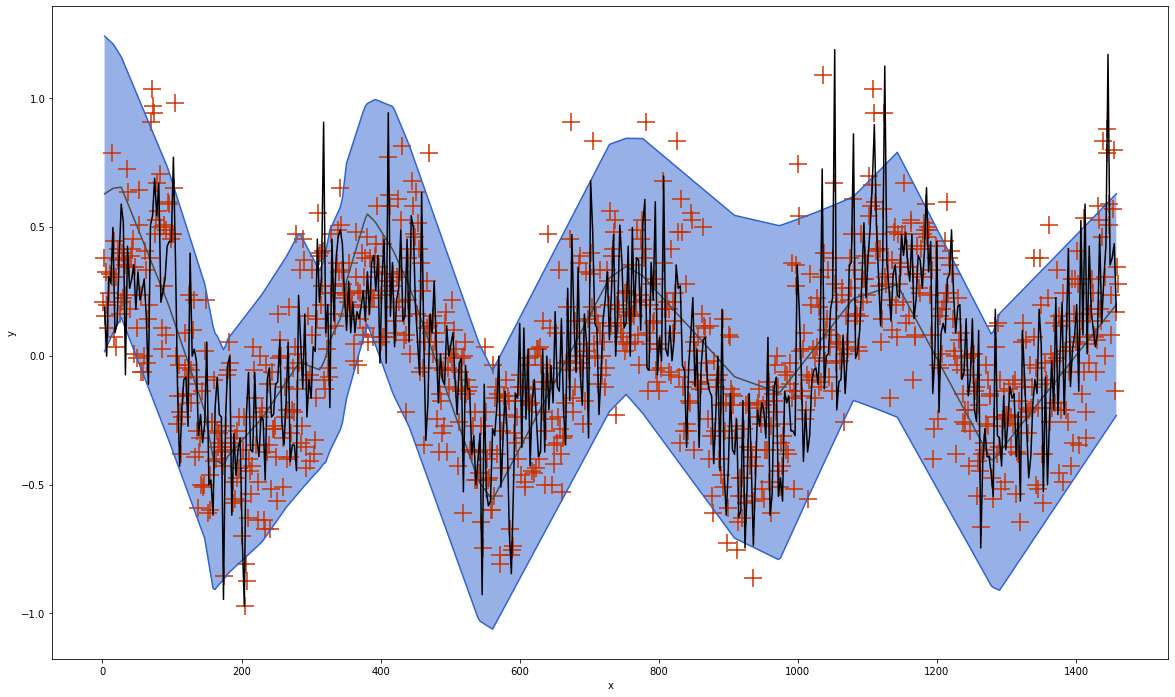

MSE CNP:    0.07


In [33]:
plt.figure(figsize=(20,12))
pred_cnp, max_pred_cnp, min_pred_cnp = cnp_predict(xc_train, yc, xt_train, np.transpose([xt_train, yt]))
print("MSE CNP: {0:7.2f}".format((np.square(yt - pred_cnp[:,1])).mean()))

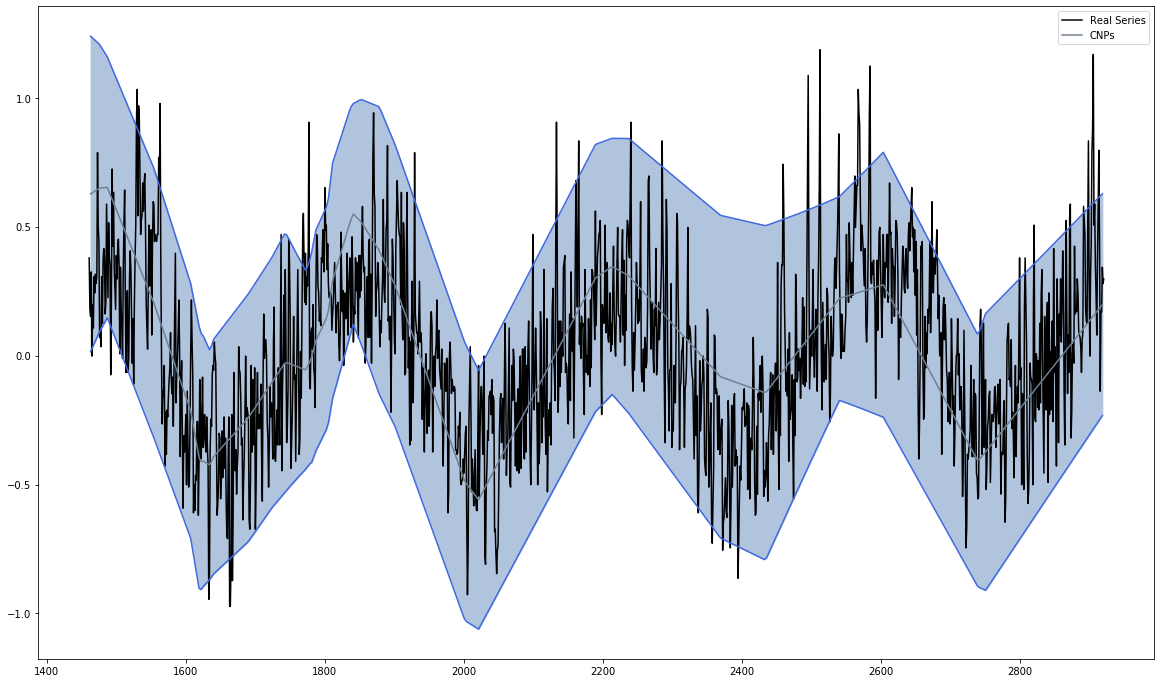

In [34]:
y_pred_cnp_1=pd.DataFrame(pred_cnp, index=xt.astype(int))[1]

max_pred_cnp_1=pd.DataFrame(max_pred_cnp, index=xt.astype(int))[1]

min_pred_cnp_1=pd.DataFrame(min_pred_cnp, index=xt.astype(int))[1]

plt.figure(figsize=(20,12))
plt.plot(y_test_1, label='Real Series', color='black')
plt.plot(y_pred_cnp_1, label='CNPs', color='slategrey')
plt.plot(max_pred_cnp_1, color='royalblue')
plt.plot(min_pred_cnp_1,color='royalblue')
plt.fill_between(xt.astype(int),
                 max_pred_cnp_1,
                min_pred_cnp_1,
                color='lightsteelblue')
plt.legend()
plt.show()